# 2. osmFISH mouse somatosensory cortex datasets
Detection of spatial domains in the osmFISH (imgae-based) mouse somatosensory cortex dataset.

The mouse somatosensory cortex dataset, generated using the osmFISH platform, includes 5,328 spots at single-cell resolution, based on the targeted detection of 33 genes.
## Preparation

In [1]:
import sys
import time
from spatialFuser import *
import scanpy as sc
sys.path.append("..")

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Hyper-Parameters setting
All hyperparameters are stored in the variable args. To display them during initialization, use the function call *args = def_training_args(show_detail=True)*.

Unlike the DLPFC dataset, for low-throughput spatial transcriptomics data, SpatialFuser adopts simpler MCGATE architecture (a single layer with 32 dimensions) to learn data embeddings.

In [2]:
# load args:
print("============================================")
print("=              Setting Params              =")
args = def_training_args()
args.epochs = 500
args.K = 10
args.step = 100
args.heads = 4
args.alpha = 0
args.hidden = [32]
args.lr = 8e-3

=              Setting Params              =


## Load data
SpatialFuser provides a built-in data loading and preprocessing module, *SpatialFuserDataLoader*. The required inputs include hyperparameters, data_dir (the dataset storage directory), data_tech (either “seq-based” or “image-based”), and files (a list of h5ad files to be loaded).

For spatial omics data, *SpatialFuserDataLoader* constructs a KNN adjacency graph based on the specified value of K to support graph neural network training.

For seq-based data, spatially variable genes are extracted according to n_svgs to simplify the model.

All AnnData objects are normalized, log-transformed, and subsequently converted into PyG objects for model input.

In [3]:
# load data:
print("============================================")
print("=               Loading Data               =")
loadtime = time.time()
dataLoader = SpatialFuserDataLoader(args,
                                    data_dir='/public8/lilab/student/whcai/Integration/data/osmFISH_mouse_cortex',
                                    data_tech='image-based',
                                    files=['osmFISH_codeluppi2018spatial_cortex_data.h5ad'])
dataLoader.load_adata()
dataLoader.remove_type(obs_name='Region', target='Excluded')
dataLoader.pre_processing(n_svgs=3000, k_cutoff=args.K, batch_label=[1])
dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

=               Loading Data               =


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 53229 edges, 4839 cells=
=   11.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 4839 nodes           =
=   10.0000 neighbors per cell on average   =
batch:[1.], node num:[4839]


## Train MCGATE

In [4]:
# train
print("============================================")
print("=              Begin to Train              =")
training_time = time.time()
# Train model
adata, trainer, loss_list = train_emb(args, dataLoader)
print("=            Training Finished!            =")
print("Total time elapsed: {:.4f}s".format(time.time() - training_time))
print("============================================")

=              Begin to Train              =


Epoch500 || loss: 3.7744 || MNN num: [0]: 100%|███████████████████████████████████████| 500/500 [00:20<00:00, 23.98it/s]

=            Training Finished!            =
Total time elapsed: 21.2140s



/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:392: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  dataLoader.adata.uns['MCGATE_loss'] = loss_list


## Show trainable parameters number

Because the input dimensionality for the osmFISH dataset is much lower than that of the DLPFC dataset, the corresponding MCGATE model requires far fewer parameters.

In [5]:
# show param number
total_params, total_trainable_params = show_para_num(trainer.model)
param_num = {'total_params': total_params,
             'trainable_params': total_trainable_params,
             'non-trainable_params': total_params - total_trainable_params}

1,763 total parameters.
0.00M total parameters.
1,568 training parameters.
0.00M training parameters.


## Evaluation and plot based on mclust
SpatialFuser provides an evaluation module, *metrics*, for assessing tissue domain detection tasks. It treats the Region column in anndata.obs as the ground truth and, based on the provided embed_label (an array stored in anndata.obsm), automatically computes five metrics (ARI, AMI, Homogeneity, Completeness, and V-Measure) under clustering methods including Leiden, Louvain, and Mclust.

Here, we only show the spatial domains colored by Mclust with customized colors.

2025-08-25 19:44:01.344448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 19:44:01.577980: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 19:44:03.473932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/cv2/../../lib64::/usr/local/

fitting ...
  |======================================================================| 100%
             ARI       AMI Homogeneity Completeness V_Measure
mclust  0.611863  0.711322    0.730317      0.69597   0.71273


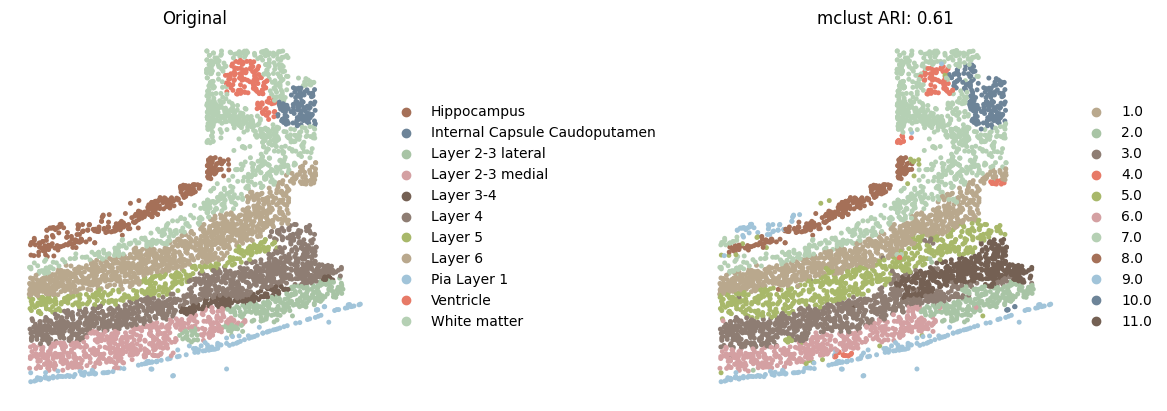

In [6]:
# evaluate and plot
leiden_result, louvain_result, mclust_result = metrics(adata,
                                                       save_loc='_osmFISH.png',
                                                       resolution=0.1,
                                                       spot_size=0.015,
                                                       cluster_label='Region',
                                                       plot_color=["mclust"],
                                                       mclust_model='EEE',
                                                       embed_label='embedding',
                                                       vis=False,
                                                       save=False)
print(mclust_result)

sc.tl.umap(adata)
adata.obs['mclust'] = adata.obs['mclust'].astype(str)

region_color = {
    'Pia Layer 1': "#A1C4D9",
    'Layer 2-3 medial': "#D4A0A2",
    'Layer 2-3 lateral': "#A8C4A5",
    'Layer 3-4': "#746053",
    'Layer 4': "#8E7D73",
    'Layer 5': "#A8B86A",
    'Layer 6': "#B9A88D",
    'White matter': "#B5D0B4",
    'Internal Capsule Caudoputamen': "#6D8498",
    'Hippocampus': "#A57058",
    'Ventricle': "#E77A67",
    '1.0': "#B9A88D",
    '2.0': "#A8C4A5",
    '3.0': "#8E7D73",
    '4.0': "#E77A67",
    '5.0': "#A8B86A",
    '6.0': "#D4A0A2",
    '7.0': "#B5D0B4",
    '8.0': "#A57058",
    '9.0': "#A1C4D9",
    '10.0': "#6D8498",
    '11.0': "#746053",
}

sc.pl.spatial(adata, img_key="hires", color=['Region', "mclust"],
              spot_size=0.015,
              title=['Original',
                     'mclust ARI: {:.2f}'.format(mclust_result['ARI'][0])],
              wspace=0.23,
              palette=region_color,
              frameon=False,
              save='_osmFISH.png'
              )